**Deep Neural Network Algorithm to Control a Curved Kicking Mechanism in RoboCup Small Size League**

**JINT**

Francisco Arthur Bonfim Azevedo - arthurazevedo41@gmail.com

Guilherme Pinheiro Cordeiro Leão - guipcleao@gmail.com

Marcos Ricardo Omena de Albuquerque Maximo

The latest version of this project is available at https://github.com/GuiPCLeao/SS-Curved-Kick

In [1]:
# Cleaning all saved variables:
%reset_selective -f "^a$"

In [2]:
import zipfile
import os

# download training dataset from google drive:
!gdown --id 1SII7pa-RBtZcKlp4ibYhVVheoRGiug6X

with zipfile.ZipFile("datasets.zip","r") as zip_ref:
  zip_ref.extractall() # extracts in current directory

# make results folder to save images
if not os.path.exists('results'):
  os.makedirs('results') 
os.remove("datasets.zip")

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SII7pa-RBtZcKlp4ibYhVVheoRGiug6X
To: /content/datasets.zip
100% 6.75M/6.75M [00:00<00:00, 26.5MB/s]


In [3]:
print('AVAILABLE DATASET FILES:')
data = []
for filename in os.listdir('.'):
  if filename.endswith("csv"): 
    # Your code comes here such as 
    print(f"- {filename}")
    data.append(filename)

AVAILABLE DATASET FILES:
- LargeNoCutOutTol06.csv
- dataset_with_adversaries.csv
- LargeCutOutTol03.csv
- LargeCutOutTol06.csv
- LargeNoCutOutTol03.csv
- SmallCutOutTol06.csv
- SmallNoCutOutTol06.csv


In [4]:
import pandas as pd

df = pd.read_csv('dataset_with_adversaries.csv')

training_df = df.sample(frac=0.8,random_state=200) 
validation_df = df.drop(training_df.index)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, losses, optimizers, activations, metrics, regularizers, utils
import os
import math

class SSAgent:
  """
  Represents a Deep Q-Networks (DQN) SS agent.
  """
  def __init__(self, training_df, validation_df, num_epochs=5000, batch_size=50, lambda_l2=0.0, learning_rate=0.001):
    """
    Creates a Deep Q-Networks (DQN) SS agent.

    :param training_df: dataset used for training the neural network.
    :type training_df: pandas.DataFrame.
    :param validation_df: dataset used for validating the neural network.
    :type validation_df: pandas.DataFrame.
    :param num_epochs: number of training epochs.
    :type num_epochs: int.
    :param batch_size: size of the mini-batches used during training.
    :type batch_size: int.
    :param lambda_l2: lambda parameter of the L2 regularization.
    :type lambda_l2: float.
    :param learning_rate: learning rate of the action-value neural network.
    :type learning_rate: float.
    """
    self.features_names = [
      'Ally_1_row', 'Ally_1_col',
      'Ally_2_row', 'Ally_2_col',
      'Ally_3_row', 'Ally_3_col',
      'Ally_4_row', 'Ally_4_col',
      'Ally_5_row', 'Ally_5_col',
      'Adv_1_row', 'Adv_1_col',
      'Adv_2_row', 'Adv_2_col',
      'Adv_3_row', 'Adv_3_col',
      'Adv_4_row', 'Adv_4_col',
      'Adv_5_row', 'Adv_5_col',
      'Adv_6_row', 'Adv_6_col',
      'Target_row', 'Target_col',
      'ini_row', 'ini_col'
    ]
    self.output_names = ['V', 'W', 'Theta']
    self.lambda_l2 = lambda_l2
    self.num_epochs = num_epochs
    self.training_input = training_df.loc[:,self.features_names]
    self.expected_output = training_df.loc[:,self.output_names]
    self.validation_input = validation_df.loc[:,self.features_names]
    self.validation_output = validation_df.loc[:,self.output_names]
    self.input_size = self.training_input.shape[1]
    self.output_size = self.expected_output.shape[1]
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.model = self._make_model()

  def _make_model(self):
    """
    Makes the neural network model using Keras.

    :return: sequential neural network.
    :rtype: Keras' model.
    """
    model = models.Sequential()

    # LAYER 1:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 75
    model.add(layers.Dense(number_of_neurons,
                           name='1_dense_' + str(number_of_neurons) + '_leaky_relu',
                           input_dim=self.input_size,
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    # LAYER 2:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 30
    model.add(layers.Dense(number_of_neurons,
                           name='2_dense_' + str(number_of_neurons) + '_leaky_relu',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    # LAYER 3:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 40
    model.add(layers.Dense(number_of_neurons,
                           name='3_dense_' + str(number_of_neurons) + '_leaky_relu',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    # LAYER 4:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 50
    model.add(layers.Dense(number_of_neurons,
                           name='4_dense_' + str(number_of_neurons) + '_leaky_relu',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    # LAYER 5:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 40
    model.add(layers.Dense(number_of_neurons,
                           name='5_dense_' + str(number_of_neurons) + '_leaky_relu',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    # LAYER 6:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 30
    model.add(layers.Dense(number_of_neurons,
                           name='6_dense_' + str(number_of_neurons) + '_leaky_relu',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    # LAYER 7:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 20
    model.add(layers.Dense(number_of_neurons,
                           name='7_dense_' + str(number_of_neurons) + '_leaky_relu',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    # LAYER 8:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 20
    model.add(layers.Dense(number_of_neurons,
                           name='8_dense_' + str(number_of_neurons) + '_leaky_relu',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    # LAYER 9:
    activation_function = layers.LeakyReLU(alpha=0.01)
    number_of_neurons = 20
    model.add(layers.Dense(number_of_neurons,
                           name='9_dense_' + str(number_of_neurons) + '_leaky_relu',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))

    # LAYER 10:
    activation_function = activations.linear
    number_of_neurons = self.output_size
    model.add(layers.Dense(number_of_neurons,
                           name='10_dense_' + str(number_of_neurons) + '_linear',
                           activation=activation_function,
                           use_bias=True,
                           kernel_regularizer=regularizers.l2(self.lambda_l2)))
    
    model.compile(loss=losses.mse,
                  optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                  metrics=['accuracy'])
    model.summary()
    return model

  def train(self):
    """
    Train the keras model and saves training and validation history.
    """
    self.history = self.model.fit(self.training_input,
                                  self.expected_output,
                                  validation_data=(self.validation_input,self.validation_output),
                                  batch_size=self.batch_size,
                                  epochs=self.num_epochs)

  def show_results(self):
    """
    Plot the training and validation loss history and saves it to results folder.
    """
    fig_formats = ['png', 'eps']

    # Plotting cost function convergence
    plt.plot(self.history.history['loss'], label='Train')
    plt.plot(self.history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Cost Function Convergence')
    plt.grid()
    plt.legend()
    for fig_format in fig_formats:
      try:
        plt.savefig('results/convergence.' + fig_format, format=fig_format)
      except:
        print(f"failed to save figure with extension .{fig_format}")

  def save(self):
    """
    Saves the trained model and model's weights to results folder.
    """
    self.model.save_weights("results/weights.h5")
    self.model.save("results/model.h5")
    utils.plot_model(self.model,
                     to_file='results/model_plot.png',
                     show_shapes=True,
                     show_layer_names=True)



In [6]:
# Comment this line to enable training using your GPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

num_epochs = 100  # number of epochs for training
batch_size = 50
#batch_size = int(training_df.shape[0] / 4)
lambda_l2 = 0.002 # reduce overfitting
learning_rate = 0.001


ss_agent = SSAgent(training_df, validation_df, num_epochs, batch_size, lambda_l2, learning_rate)
ss_agent.train()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1_dense_75_leaky_relu (Dens  (None, 75)               2025      
 e)                                                              
                                                                 
 2_dense_30_leaky_relu (Dens  (None, 30)               2280      
 e)                                                              
                                                                 
 3_dense_40_leaky_relu (Dens  (None, 40)               1240      
 e)                                                              
                                                                 
 4_dense_50_leaky_relu (Dens  (None, 50)               2050      
 e)                                                              
                                                                 
 5_dense_40_leaky_relu (Dens  (None, 40)               2

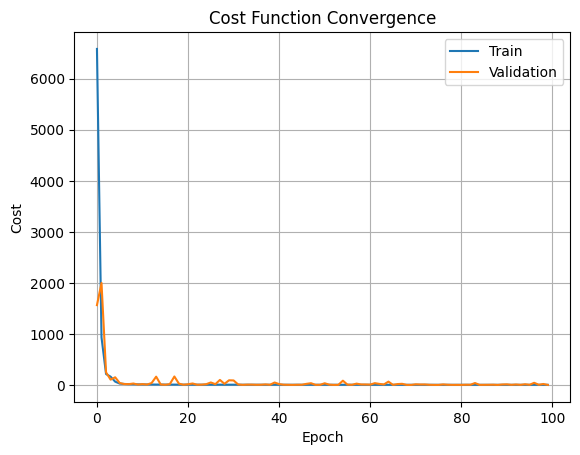

In [7]:
ss_agent.show_results()

In [8]:
input_names = [
  'Ally_1_row', 'Ally_1_col',
  'Ally_2_row', 'Ally_2_col',
  'Ally_3_row', 'Ally_3_col',
  'Ally_4_row', 'Ally_4_col',
  'Ally_5_row', 'Ally_5_col',
  'Adv_1_row', 'Adv_1_col',
  'Adv_2_row', 'Adv_2_col',
  'Adv_3_row', 'Adv_3_col',
  'Adv_4_row', 'Adv_4_col',
  'Adv_5_row', 'Adv_5_col',
  'Adv_6_row', 'Adv_6_col',
  'Target_row', 'Target_col',
  'ini_row', 'ini_col'
]
output_names = ['V', 'W', 'Theta']

expected_output = validation_df.loc[:, output_names]
validation_inputs = validation_df.loc[:, input_names]

test_metrics = ss_agent.model.evaluate(validation_inputs, expected_output)
print('Test loss:', test_metrics[0])
print('Test accuracy:', test_metrics[1])

1567/1567 [==============================] - 8s 5ms/step - loss: 9.8181 - accuracy: 1.0000
Test loss: 9.818086624145508
Test accuracy: 1.0


In [9]:
from google.colab import files
import os
ss_agent.save()
os.system('zip -r results.zip results')
files.download("results.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>